In [2]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Optim
using Plots
using Random
using SSM

In [3]:
Random.seed!(1234)

g = 9.81
l=1
# time differential
dt = 0.01
# transition matrix
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0, 1.0]
# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 0.01 * I(2)  # Process noise covariance
observation_noise_std = 0.5
R = (observation_noise_std^2) * I(2)  # Observation noise covariance
p0 = 0.1*I(2)  # Initial state covariance

lds = SSM.LDS(;A=A, H=H, Q=Q, R=R, x0=x0, p0=p0, obs_dim=2, latent_dim=2)

x, y = SSM.sample(lds, 100)

([-0.11375626857646887 1.343805512755226; -0.05829349566953871 1.2863979124749656; … ; 0.38927459888641114 0.060924881414345565; 0.2173556424880684 0.0922845673904967], [-0.32355107704589325 1.7032604814881955; 0.9690880323624795 1.4488442771984236; … ; -0.039807549312631696 0.06407608359556304; 0.20445211038157346 -0.0018833125233974485])

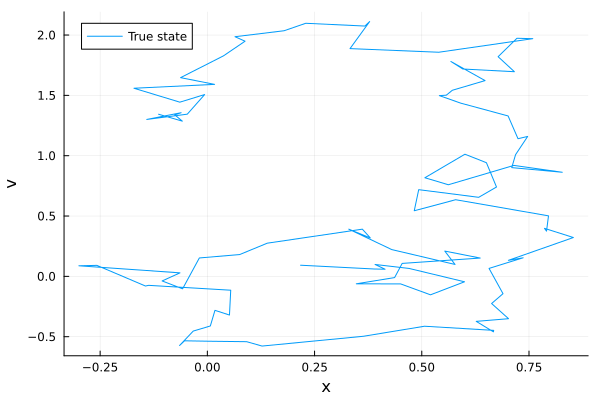

In [3]:
plot(x[:, 1], x[:, 2], label="True state", xlabel="x", ylabel="v", legend=:topleft)

In [3]:
test_lds = SSM.LDS(;obs_dim=2, latent_dim=2, fit_bool=[true, true, true, true, true, true, true])
test_lds.A = [1.0 1.0; 1.0 1.0]
test_lds.H = [0.8 0; 0.0 0.8]
test_lds.Q = [1.0 0.0; 0.0 1.0]
test_lds.R = [1.0 0.0; 0.0 1.0]
test_lds.x0 = [0.0, 0.0]
test_lds.p0 = [1.0 0.0; 0.0 1.0]

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [4]:
function sufficient_statistics(μ::Matrix{<:Real}, P::Array{<:Real}, P_tt1::Array{<:Real})
    # Get dimensions
    T, D = size(μ)
    # Initialize sufficient statistics
    E_z = zeros(T, D)
    E_zz = zeros(T, D, D)
    E_zz_prev = zeros(T, D, D)
    # Compute sufficient statistics
    for t in 1:T
        E_z[t, :] = μ[t, :]
        E_zz[t, :, :] = P[t, :, :] + (μ[t, :] * μ[t, :]')
        if t > 1
            E_zz_prev[t, :, :] = (P_tt1[t-1, :, :]') + (μ[t, :] * μ[t-1, :]')
        end
    end
    return E_z, E_zz, E_zz_prev
end

x_sm, p_sm, ptt1 = SSM.KalmanSmoother(test_lds, y, "Direct")
E_z, E_zz, E_zz_prev = sufficient_statistics(x_sm, p_sm, ptt1)


Norm of gradient iterate difference: 6.0539979027119655
Converged at iteration 2


([-0.2702085619477476 0.7184800031908323; 0.23910713301161973 0.47313456951695826; … ; 0.02770568069692386 0.07838062357897006; 0.16441950767143457 0.06376808186413167], [0.4818826675709465 -0.3950255453903063; 0.4840358676546264 -0.06976260051749889; … ; 0.5167016091208484 -0.0916505046533021; 0.9506743985324839 0.32436924309384374;;; -0.3950255453903062 0.9250835156061753; -0.06976260051749889 0.6507199674695872; … ; -0.09165050465330238 0.5220775265305967; 0.32436924309384374 0.9277069922941975], [0.0 0.0; -0.021351490372056872 -0.08458770744648214; … ; 0.09322302836136458 0.10315574125619945; 0.26194066608413513 0.25915204981902773;;; 0.0 0.0; 0.215050997879601 0.38319503120669896; … ; 0.08405941982922317 0.07723147832832418; 0.27027261524407925 0.2623834937251902])

In [5]:
dropdims(sum(E_zz_prev, dims=1), dims=1) * pinv(dropdims(sum(E_zz[1:end-1, :, :], dims=1), dims=1))

2×2 Matrix{Float64}:
 0.263766  0.239708
 0.366993  0.489321

In [8]:
Q_L = Matrix(cholesky(test_lds.Q).L)
R_L = Matrix(cholesky(test_lds.R).L)
P0_L = Matrix(cholesky(test_lds.p0).L)
# SSM.Q(test_lds.A, Q_L, test_lds.H, R_L, P0_L, test_lds.x0, E_z, E_zz, E_zz_prev, y)
function Q_fun(A::Matrix{<:Real}, Q::Matrix{<:Real}, H::Matrix{<:Real}, R::Matrix{<:Real}, P0::Matrix{<:Real}, x0::Vector{<:Real}, E_z::Matrix{<:Real}, E_zz::Array{<:Real}, E_zz_prev::Array{<:Real}, y::Matrix{<:Real})
    # get the number of observations
    T = size(y, 1)
    # Convert Q, R, and P0 to proper matrices
    Q = Q * Q'
    R = R * R'
    P0 = P0 * P0'
    # calculate the inverses
    R_inv = pinv(R)
    Q_inv = pinv(Q)
    P0_inv = pinv(P0)
    # Calculate the Q-function
    Q_val = 0.0
    # Calculate the Q-function for the first time step
    Q_val += -0.5 * (logdet(P0) + tr(P0_inv * (E_zz[1, :, :] - 2*(E_z[1, :] * x0') + (x0 * x0'))))
    # Calculate the Q-function for the state model
    for t in 2:T
        # Individual terms
        term1 = E_zz[t, :, :]
        term2 = A * E_zz_prev[t, :, :]'
        term3 = E_zz_prev[t, :, :] * A'
        term4 = A * E_zz[t-1, :, :] * A'
        # Calculate the Q-value
        q_val = -0.5 * (logdet(Q) + tr(Q_inv * (term1 - term2 - term3 + term4)))
        Q_val += q_val
    end
    # Calculate the Q-function for the observation model
    for t in 1:T
        # Individual terms
        term1 = y[t, :] * y[t, :]'
        term2 = H * (E_z[t, :] * y[t, :]')
        term3 = (y[t, :] * E_z[t, :]') * H'
        term4 = H * E_zz[t, :, :] * H'
        # Calculate the Q-value`
        q_val = -0.5 * (logdet(R) + tr(R_inv * (term1 - term2 - term3 + term4)))
        Q_val += q_val
    end
    return -Q_val
end

res = optimize(Q -> Q_fun(test_lds.A, Q, test_lds.H, R_L, P0_L, test_lds.x0, E_z, E_zz, E_zz_prev, y), [0.9 0.1; 0.1 0.9], LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000))

 * Status: success

 * Candidate solution
    Final objective value:     8.301179e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.25e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.68e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.85e-16 ≰ 0.0e+00
    |g(x)|                 = 8.21e-09 ≤ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    11
    f(x) calls:    33
    ∇f(x) calls:   33


In [9]:
res.minimizer * res.minimizer'

2×2 Matrix{Float64}:
  0.466308  -0.232065
 -0.232065   0.518897

In [29]:
E_zz[1, :, :]

2×2 Matrix{Float64}:
  0.481883  -0.395026
 -0.395026   0.925084

In [33]:
SSM.KalmanFilterEM!(test_lds, y, 1)

1-element Vector{Any}:
 -343.8168584590312

In [36]:
test_lds.Q

2×2 Matrix{Float64}:
  0.466308  -0.232065
 -0.232065   0.518897

In [15]:
function Q_fun(A, Q, E_z, E_zz, E_zz_prev)
    Q_inv = inv(Q)
    ll = 0.0
    
    for i in 2:size(E_z, 1)
        term1 = E_zz[i, :, :]
        term2 = A * E_zz_prev[i, :, :]'
        term3 = E_zz_prev[i, :, :] * A'
        term4 = A * E_zz[i-1, :, :] * A'
        
        q_val = tr(Q_inv * (term1 - term2 - term3 + term4))
        # println("Step $i: Q_inv * (E_zz[i, :, :] - A * E_zz_prev[i, :, :]' - E_zz_prev[i, :, :] * A' + A * E_zz[i-1, :, :] * A') = $q_val")
        
        ll += -0.5 * q_val
    end
    
    return -ll
end

Q_fun(test_lds.A, test_lds.Q, E_z, E_zz, E_zz_prev)

res = optimize(A -> Q_fun(A, test_lds.Q, E_z, E_zz, E_zz_prev), test_lds.A, LBFGS(), autodiff=:forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.832845e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.40e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.81e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.66e-01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.18e-02 ≰ 0.0e+00
    |g(x)|                 = 4.08e-15 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    5
    ∇f(x) calls:   5


In [14]:
temp_A = dropdims(sum(E_zz_prev, dims=1), dims=1) * pinv(dropdims(sum(E_zz[1:end-1, :, :], dims=1), dims=1))

2×2 Matrix{Float64}:
 0.630294  0.524184
 0.733521  0.773796

In [29]:
test_lds.A

2×2 Matrix{Float64}:
  0.852832  0.0590566
 -0.105337  1.01303

In [8]:
function obj(A, x_sm)
    ll = 0.0
    for i in 2:size(x_sm, 1)
        ll += sum((x_sm[i, :]-A*x_sm[i-1, :]).^2)
    end
    return ll
end

obj (generic function with 1 method)

In [9]:
x_sm, p_sm, ptt1 = SSM.KalmanSmoother(test_lds, y, "Direct")
res = Optim.optimize(A -> obj(A, x_sm), test_lds.A, LBFGS())

Norm of gradient iterate difference: 14.271104827909165
Converged at iteration 2


 * Status: success

 * Candidate solution
    Final objective value:     9.686203e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.37e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.34e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.50e-16 ≰ 0.0e+00
    |g(x)|                 = 7.24e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    5
    ∇f(x) calls:   5


In [28]:
res.minimizer

2×2 Matrix{Float64}:
 0.456365  0.21557
 0.392621  0.810555

In [14]:
z = ones(10, 2, 2)
z_new = cat(zeros(1, 2, 2), z, dims=1)

z_new[4, :, :]

2×2 Matrix{Float64}:
 1.0  1.0
 1.0  1.0